Self Organizing Map

A self-organizing map (SOM) or self-organizing feature map (SOFM) is an unsupervised machine learning technique used to produce a low-dimensional (typically two-dimensional) representation of a higher dimensional data set while preserving the topological structure of the data.
An SOM is a type of artificial neural network but is trained using competitive learning rather than the error-correction learning (e.g., backpropagation with gradient descent) used by other artificial neural networks. The SOM was introduced by the Finnish professor Teuvo Kohonen in the 1980s and therefore is sometimes called a Kohonen map or Kohonen network.
Each node in the map space is associated with a "weight" vector, which is the position of the node in the input space. While nodes in the map space stay fixed, training consists in moving weight vectors toward the input data (reducing a distance metric such as Euclidean distance) without spoiling the topology induced from the map space. After training, the map can be used to classify additional observations for the input space by finding the node with the closest weight vector (smallest distance metric) to the input space vector.
The weights of the neurons are initialized either to small random values or sampled evenly from the subspace spanned by the two largest principal component eigenvectors. With the latter alternative, learning is much faster because the initial weights already give a good approximation of SOM weights.
There are two ways to interpret a SOM. Because in the training phase weights of the whole neighborhood are moved in the same direction, similar items tend to excite adjacent neurons. Therefore, SOM forms a semantic map where similar samples are mapped close together and dissimilar ones apart. This may be visualized by a U-Matrix (Euclidean distance between weight vectors of neighboring cells) of the SOM.

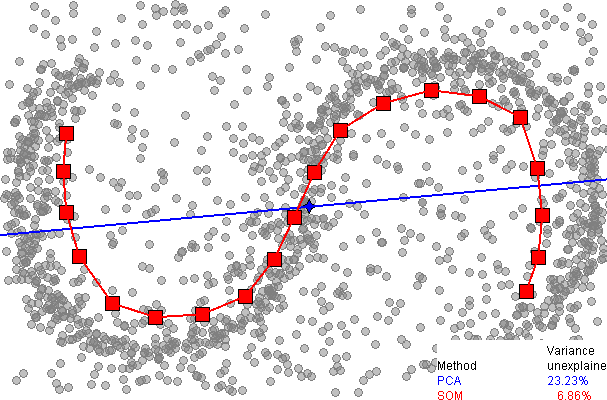

SOM may be considered a nonlinear generalization of Principal components analysis (PCA).[21] It has been shown, using both artificial and real geophysical data, that SOM has many advantages[22][23] over the conventional feature extraction methods such as Empirical Orthogonal Functions (EOF) or PCA.

CLUSTERING

In [2]:
pip install minisom

  Preparing metadata (setup.py) ... done
  Created wheel for minisom: filename=MiniSom-2.3.1-py3-none-any.whl size=10588 sha256=732f81ee37d0bb6d75754017a380dfe1a33e9993e9efdf489ad3c87e10e175a8
  Stored in directory: /root/.cache/pip/wheels/c7/92/d2/33bbda5f86fd8830510b16aa98c8dd420129b5cb24248fd6db
Successfully built minisom


In [7]:
import pandas as pd
import numpy as np
df = pd.read_csv('/content/bilkav.com_musteriler.csv', delimiter=',')
data = df.drop(["No", "Cinsiyet"], axis = 1)
#normalizing
data = (data - np.mean(data, axis=0)) / np.std(data, axis=0)
data = data.values

In [8]:
from minisom import MiniSom
som_shape = (1, 3)
som = MiniSom(som_shape[0], som_shape[1], data.shape[1], sigma=.5, learning_rate=.5,
              neighborhood_function='gaussian', random_seed=10)

som.train_batch(data, 500, verbose=True)

 [ 500 / 500 ] 100% - 0:00:00 left 
 quantization error: 1.089249461069628


In [9]:
# each neuron represents a cluster
winner_coordinates = np.array([som.winner(x) for x in data]).T
# with np.ravel_multi_index we convert the bidimensional
# coordinates to a monodimensional index
cluster_index = np.ravel_multi_index(winner_coordinates, som_shape)

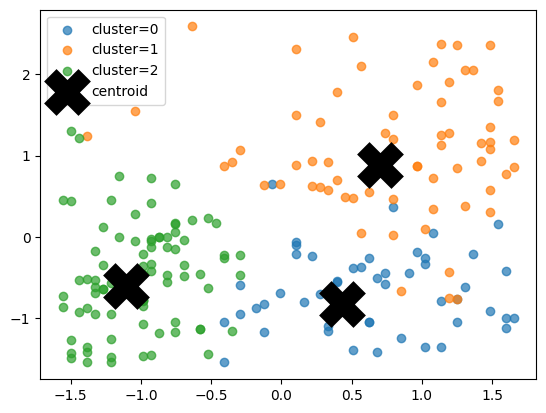

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

# plotting the clusters using the first 2 dimentions of the data
for c in np.unique(cluster_index):
    plt.scatter(data[cluster_index == c, 0],
                data[cluster_index == c, 1], label='cluster='+str(c), alpha=.7)

# plotting centroids
for centroid in som.get_weights():
    plt.scatter(centroid[:, 0], centroid[:, 1], marker='x',
                s=80, linewidths=35, color='k', label='centroid')
plt.legend();

In [25]:
from sklearn import metrics
ss = metrics.silhouette_score(data, cluster_index, metric='euclidean')
ss

0.32744190900224845

In [24]:
cluster_index

array([1, 2, 1, 0, 0, 1, 0, 2, 2, 2, 2, 2, 0, 0, 1, 1, 1, 2, 2, 0, 0, 2,
       1, 2, 1, 0, 0, 0, 2, 2, 2, 2, 0, 1, 2, 2, 0, 0, 0, 1, 1, 2, 1, 0,
       0, 0, 2, 2, 2, 1, 2, 2, 1, 1, 2, 1, 0, 1, 2, 1, 1, 1, 2, 2, 1, 0,
       2, 1, 0, 0, 1, 1, 2, 1, 0, 2, 1, 1, 0, 1, 2, 2, 2, 2, 1, 1, 1, 0,
       2, 0, 1, 0, 1, 1, 2, 2, 0, 1, 2, 2, 0, 1, 1, 2, 2, 1, 1, 0, 2, 1,
       1, 1, 1, 2, 1, 0, 0, 1, 0, 1, 2, 2, 1, 1, 2, 0, 0, 0, 1, 0, 2, 2,
       0, 0, 2, 2, 0, 2, 1, 2, 1, 0, 1, 2, 1, 2, 2, 2, 2, 0, 2, 0, 1, 2,
       2, 1, 0, 2, 1, 2, 2, 2, 1, 2, 2, 2, 2, 1, 2, 2, 1, 2, 0, 2, 2, 1,
       2, 2, 1, 0, 2, 1, 2, 1, 1, 1, 2, 2, 0, 2, 0, 2, 0, 1, 0, 1, 1, 2,
       2, 2])

CLASSIFICATION - Iris



In [86]:
import matplotlib.pyplot as plt
from matplotlib.patches import RegularPolygon, Ellipse
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import cm, colorbar
from matplotlib.lines import Line2D

from bokeh.colors import RGB
from bokeh.io import curdoc, show, output_notebook
from bokeh.transform import factor_mark, factor_cmap
from bokeh.models import ColumnDataSource, HoverTool
from bokeh.plotting import figure, output_file

# display matplotlib plots in notebook
%matplotlib inline
# display bokeh plot in notebook
output_notebook()

In [54]:
iris = pd.read_excel("/content/Iris.xls")
Y = iris["iris"]
X = iris.drop(["iris"], axis=1)

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size=0.2, random_state=0)
mms = MinMaxScaler()
X_train = mms.fit_transform(x_train)
mms = MinMaxScaler()
X_test = mms.fit_transform(x_test)

In [55]:
def classify(som, data):
    """Classifies each sample in data in one of the classes definited
    using the method labels_map.
    Returns a list of the same length of data where the i-th element
    is the class assigned to data[i].
    """
    winmap = som.labels_map(X_train, y_train)
    default_class = np.sum(list(winmap.values())).most_common()[0][0]
    result = []
    for d in data:
        win_position = som.winner(d)
        if win_position in winmap:
            result.append(winmap[win_position].most_common()[0][0])
        else:
            result.append(default_class)
    return result

In [82]:
t = y_train
data = X_train
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
t = le.fit_transform(t)

In [133]:
from sklearn.metrics import classification_report

som = MiniSom(7, 7, 4, sigma=3, learning_rate=0.5,
              neighborhood_function='triangle', random_seed=10)
#som.pca_weights_init(X_train)
som.train_random(X_train, 500, verbose=False)

print(classification_report(y_test, classify(som, X_test)))

                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        11
Iris-versicolor       1.00      1.00      1.00        13
 Iris-virginica       1.00      1.00      1.00         6

       accuracy                           1.00        30
      macro avg       1.00      1.00      1.00        30
   weighted avg       1.00      1.00      1.00        30



In [134]:
xx, yy = som.get_euclidean_coordinates()
umatrix = som.distance_map()
weights = som.get_weights()

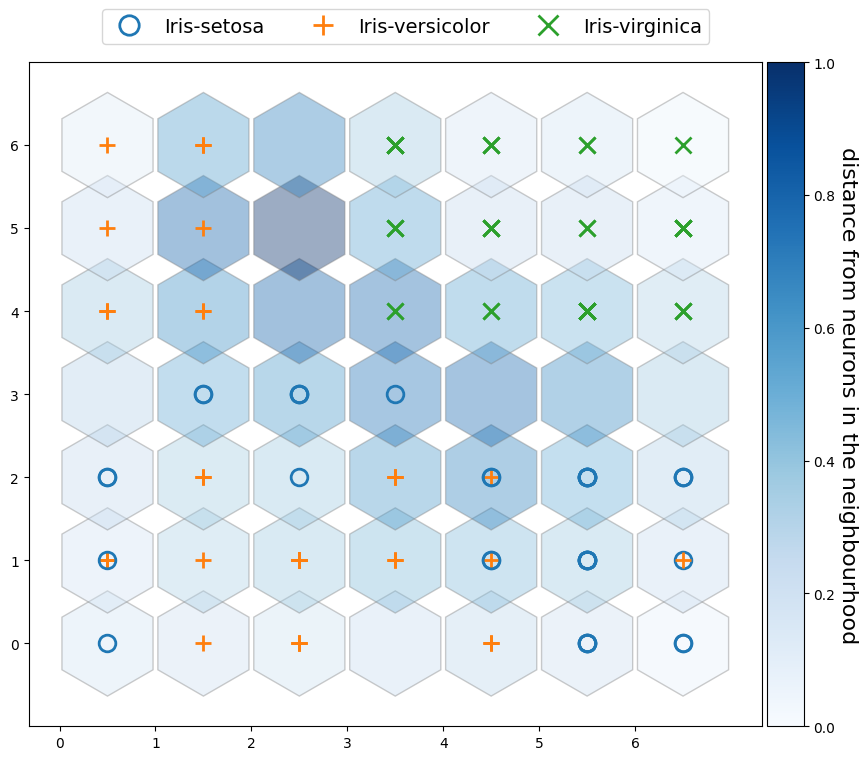

In [135]:
f = plt.figure(figsize=(10,10))
ax = f.add_subplot(111)

ax.set_aspect('equal')

# iteratively add hexagons
for i in range(weights.shape[0]):
    for j in range(weights.shape[1]):
        wy = yy[(i, j)] * np.sqrt(3) / 2
        hex = RegularPolygon((xx[(i, j)], wy),
                             numVertices=6,
                             radius=.95 / np.sqrt(3),
                             facecolor=cm.Blues(umatrix[i, j]),
                             alpha=.4,
                             edgecolor='gray')
        ax.add_patch(hex)

markers = ['o', '+', 'x']
colors = ['C0', 'C1', 'C2']
for cnt, x in enumerate(data):
    # getting the winner
    w = som.winner(x)
    # place a marker on the winning position for the sample xx
    wx, wy = som.convert_map_to_euclidean(w)
    wy = wy * np.sqrt(3) / 2
    plt.plot(wx, wy,
             markers[t[cnt]-1],
             markerfacecolor='None',
             markeredgecolor=colors[t[cnt]-1],
             markersize=12,
             markeredgewidth=2)

xrange = np.arange(weights.shape[0])
yrange = np.arange(weights.shape[1])
plt.xticks(xrange-.5, xrange)
plt.yticks(yrange * np.sqrt(3) / 2, yrange)

divider = make_axes_locatable(plt.gca())
ax_cb = divider.new_horizontal(size="5%", pad=0.05)
cb1 = colorbar.ColorbarBase(ax_cb, cmap=cm.Blues,
                            orientation='vertical', alpha=.4)
cb1.ax.get_yaxis().labelpad = 16
cb1.ax.set_ylabel('distance from neurons in the neighbourhood',
                  rotation=270, fontsize=16)
plt.gcf().add_axes(ax_cb)

legend_elements = [Line2D([0], [0], marker='o', color='C0', label='Iris-setosa',
                   markerfacecolor='w', markersize=14, linestyle='None', markeredgewidth=2),
                   Line2D([0], [0], marker='+', color='C1', label='Iris-versicolor',
                   markerfacecolor='w', markersize=14, linestyle='None', markeredgewidth=2),
                   Line2D([0], [0], marker='x', color='C2', label='Iris-virginica',
                   markerfacecolor='w', markersize=14, linestyle='None', markeredgewidth=2)]
ax.legend(handles=legend_elements, bbox_to_anchor=(0.1, 1.08), loc='upper left',
          borderaxespad=0., ncol=3, fontsize=14)

In [ ]:
#with pca_weights_init f1 score: 0.83 , with it f1 score: 1.0

In [ ]:
#learning rate ve sigma baya önemli parametreler

In [122]:
som = MiniSom(15, 15, data.shape[1], sigma=3, learning_rate=.5, activation_distance='euclidean',
              topology='hexagonal', neighborhood_function='gaussian', random_seed=10)
#som.pca_weights_init(X_train)
som.train(data, 1000, verbose=True)

print(classification_report(y_test, classify(som, X_test)))

 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 0.05545642912355973
                 precision    recall  f1-score   support

    Iris-setosa       1.00      0.64      0.78        11
Iris-versicolor       1.00      0.54      0.70        13
 Iris-virginica       0.38      1.00      0.55         6

       accuracy                           0.67        30
      macro avg       0.79      0.72      0.67        30
   weighted avg       0.88      0.67      0.70        30



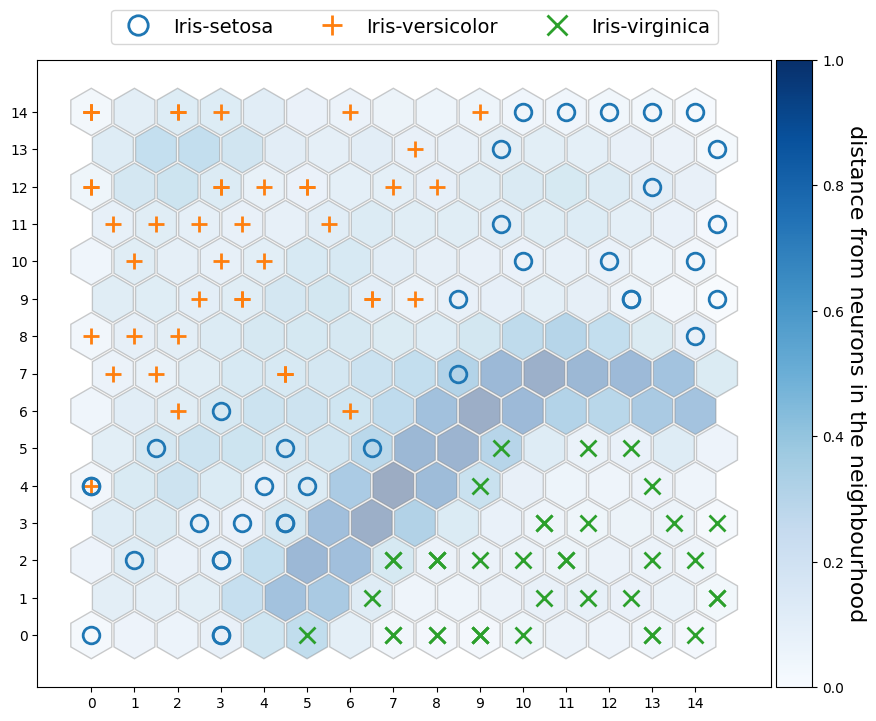

In [123]:
xx, yy = som.get_euclidean_coordinates()
umatrix = som.distance_map()
weights = som.get_weights()

f = plt.figure(figsize=(10,10))
ax = f.add_subplot(111)

ax.set_aspect('equal')

# iteratively add hexagons
for i in range(weights.shape[0]):
    for j in range(weights.shape[1]):
        wy = yy[(i, j)] * np.sqrt(3) / 2
        hex = RegularPolygon((xx[(i, j)], wy),
                             numVertices=6,
                             radius=.95 / np.sqrt(3),
                             facecolor=cm.Blues(umatrix[i, j]),
                             alpha=.4,
                             edgecolor='gray')
        ax.add_patch(hex)

markers = ['o', '+', 'x']
colors = ['C0', 'C1', 'C2']
for cnt, x in enumerate(data):
    # getting the winner
    w = som.winner(x)
    # place a marker on the winning position for the sample xx
    wx, wy = som.convert_map_to_euclidean(w)
    wy = wy * np.sqrt(3) / 2
    plt.plot(wx, wy,
             markers[t[cnt]-1],
             markerfacecolor='None',
             markeredgecolor=colors[t[cnt]-1],
             markersize=12,
             markeredgewidth=2)

xrange = np.arange(weights.shape[0])
yrange = np.arange(weights.shape[1])
plt.xticks(xrange-.5, xrange)
plt.yticks(yrange * np.sqrt(3) / 2, yrange)

divider = make_axes_locatable(plt.gca())
ax_cb = divider.new_horizontal(size="5%", pad=0.05)
cb1 = colorbar.ColorbarBase(ax_cb, cmap=cm.Blues,
                            orientation='vertical', alpha=.4)
cb1.ax.get_yaxis().labelpad = 16
cb1.ax.set_ylabel('distance from neurons in the neighbourhood',
                  rotation=270, fontsize=16)
plt.gcf().add_axes(ax_cb)

legend_elements = [Line2D([0], [0], marker='o', color='C0', label='Iris-setosa',
                   markerfacecolor='w', markersize=14, linestyle='None', markeredgewidth=2),
                   Line2D([0], [0], marker='+', color='C1', label='Iris-versicolor',
                   markerfacecolor='w', markersize=14, linestyle='None', markeredgewidth=2),
                   Line2D([0], [0], marker='x', color='C2', label='Iris-virginica',
                   markerfacecolor='w', markersize=14, linestyle='None', markeredgewidth=2)]
ax.legend(handles=legend_elements, bbox_to_anchor=(0.1, 1.08), loc='upper left',
          borderaxespad=0., ncol=3, fontsize=14)